In [5]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import os
import time
import datetime as dt
import random
import psutil
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle
import glob
import pickle
import torchvision
from torch.optim import lr_scheduler
import torch.nn.functional as F
import math
import time

import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [6]:
def no_of_params(model):
    sum_ = 0.
    for key, value in model.state_dict().items():
        sum_ += torch.prod(torch.tensor(value.shape))
        #print(value, "----------", torch.prod(torch.tensor(value.shape)))
    return int(sum_)

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        list_IDs,
    ):
        self.list_IDs  = list_IDs
        self.cache     = {}
        self.input_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/images/"
        self.label_dir = "D:/Harsh Workspace/Software/GU/instrument_position_detection_using_ML/data/set_4/labels/"
        
    def __len__(self):
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        if ID in self.cache:
            X = self.cache[ID]['X']
            Y = self.cache[ID]['Y']
        else:
            X = torchvision.io.read_image(
                self.input_dir + str(ID) + ".png "
            ).to(torch.float32)
            X = X[1].unsqueeze(0)/256.
            
            with open(self.label_dir + str(ID), 'rb') as fb:
                Y  = pickle.load(fb)
                
            #Y = [ (i + 3.)/6. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            #Y = [ i/3. for i in Y[0] ] + [i/3.14 for i in Y[1]]
            
            Y = Y[1][0]/3.1415926
            Y = torch.tensor( Y, dtype=torch.float32 ).unsqueeze(0)
            
            if psutil.virtual_memory().percent < 50:
                data = {
                    'X' : X,
                    'Y' : Y
                }
                self.cache[ID] = data
        return X,Y

In [8]:
all_ids = [str(i) for i in  list(np.arange(0,10000,1))]
train_ids = all_ids[:8000]
val_ids   = all_ids[8000:]
params = {
    'batch_size'  : 32,
    'shuffle'     : True,
    #'num_workers' : 2
}
training_set         = Dataset(train_ids)
training_generator   = torch.utils.data.DataLoader(
                            training_set,
                            **params,
                            pin_memory=True
                        )
validation_set       = Dataset(val_ids)
validation_generator = torch.utils.data.DataLoader(
                            validation_set,
                            **params,
                            pin_memory=True
                        )

In [9]:
def train_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    
    model.train(True)
    
    for i,batch in enumerate(training_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

def validate_one_epoch(
    model,
    optimizer
):
    running_loss = 0.
    loss_fn = nn.MSELoss()
    model.train(False)
    model.eval()
    
    for i,batch in enumerate(validation_generator):
        X = batch[0]
        Y = batch[1]
        output = model(batch[0])
        loss = loss_fn(Y, output)
        #optimizer.step()
        
        running_loss += loss.item()
        del X,Y,output
    
    return running_loss/(i+1)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


model = Net()
no_of_params(model)

60941

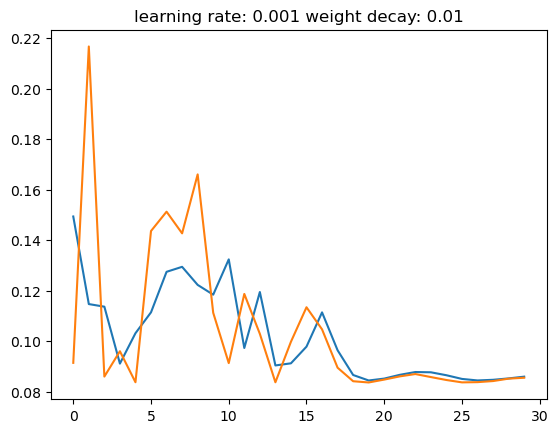

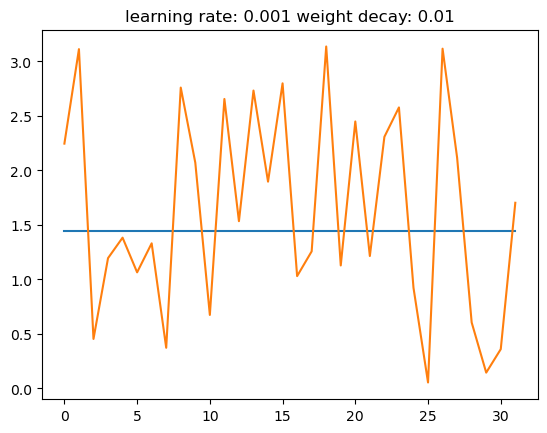

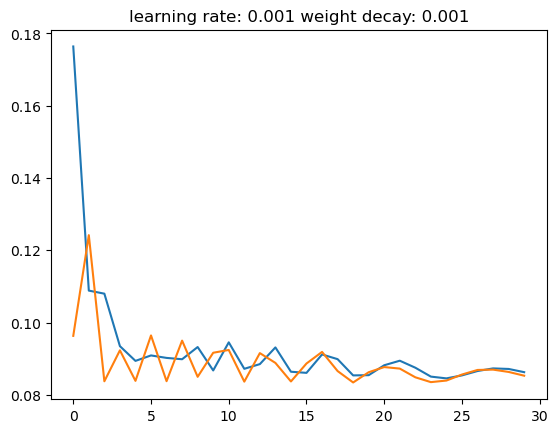

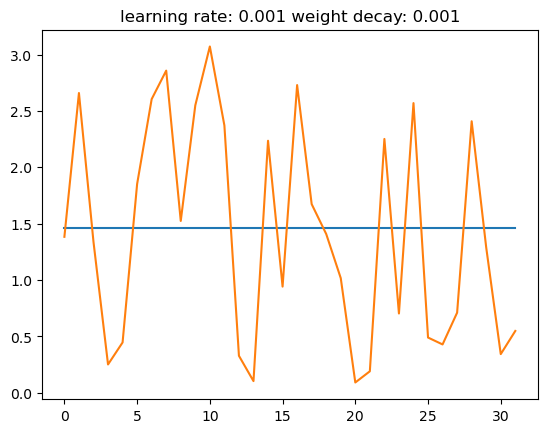

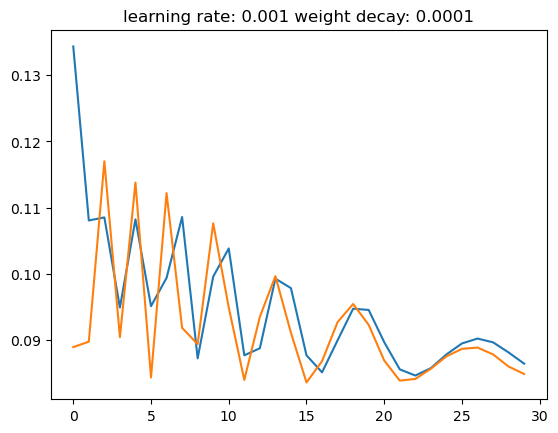

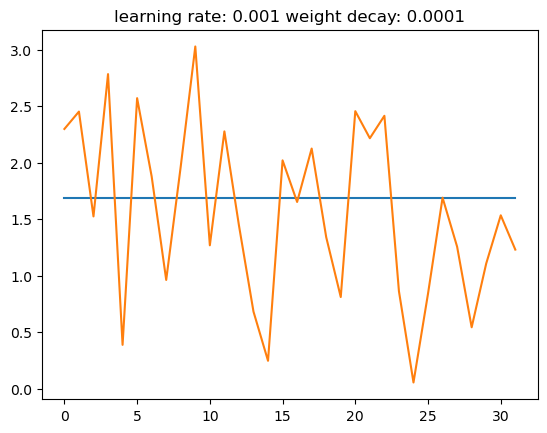

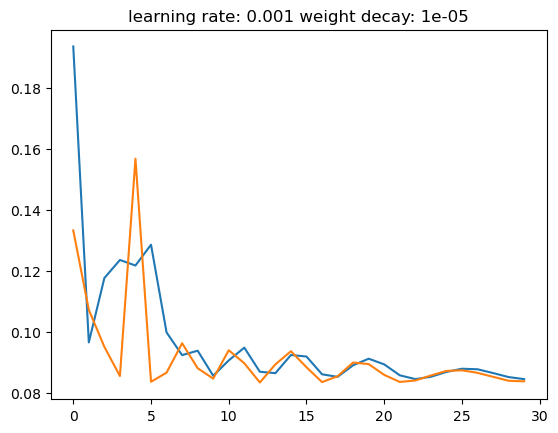

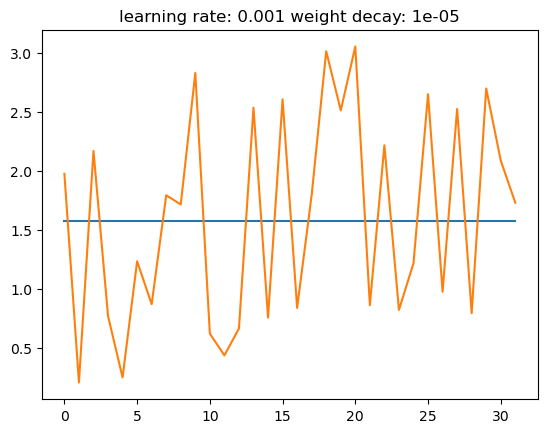

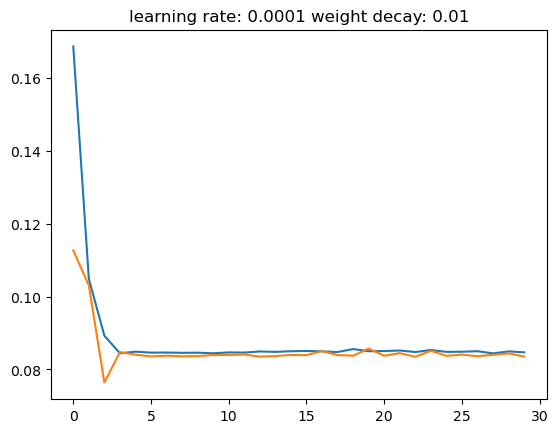

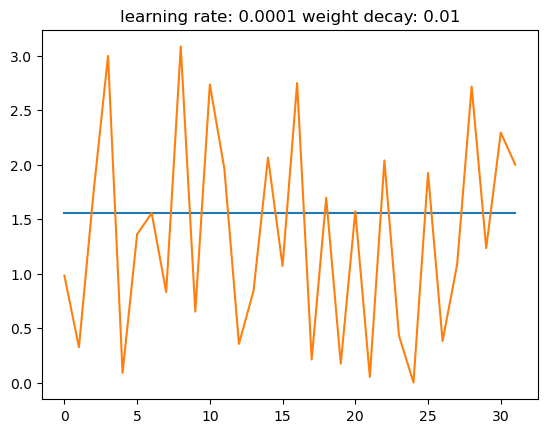

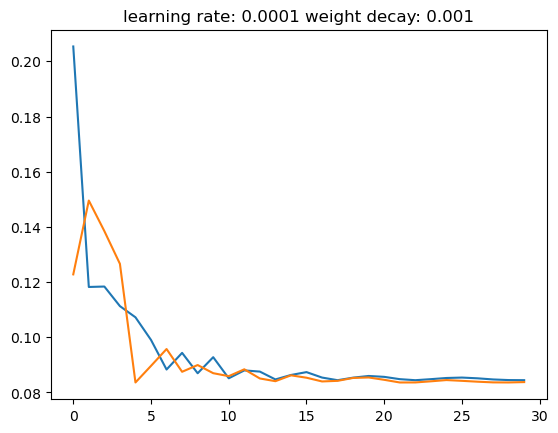

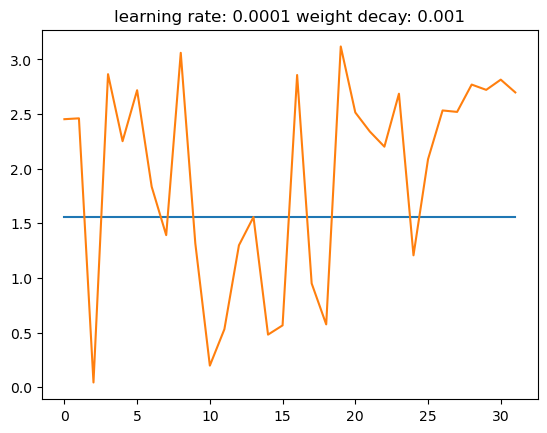

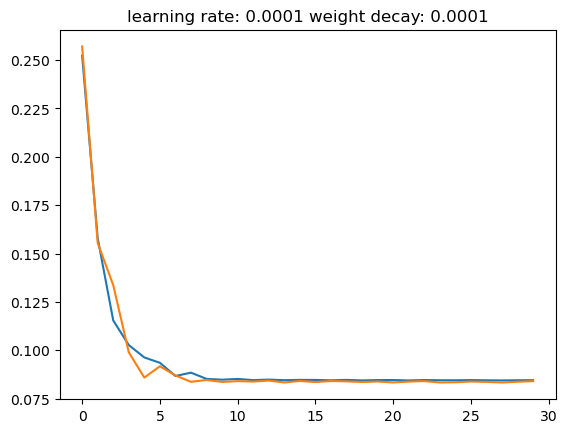

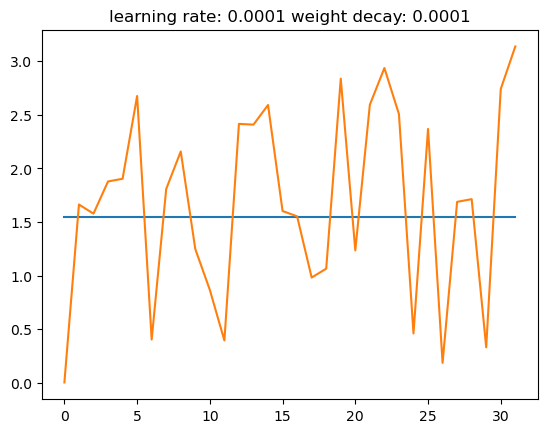

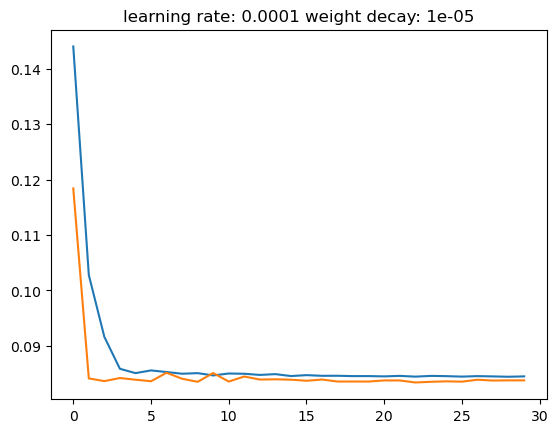

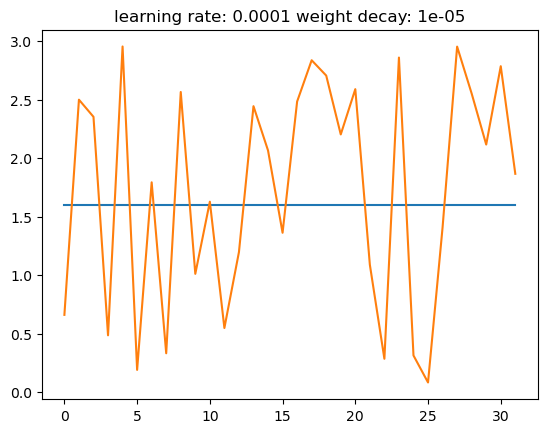

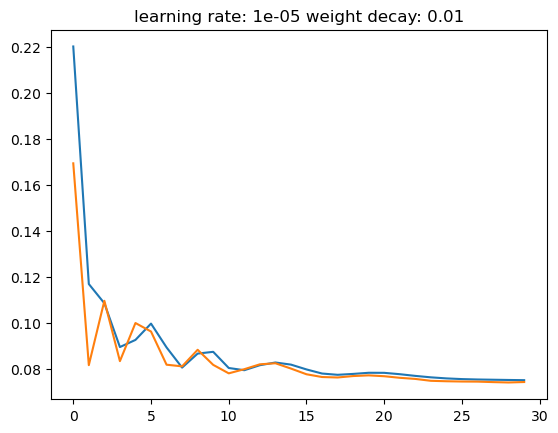

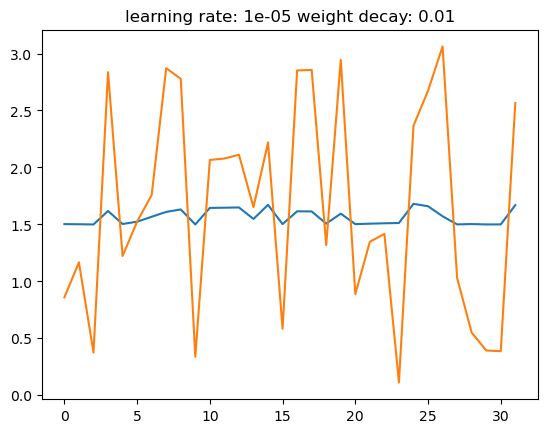

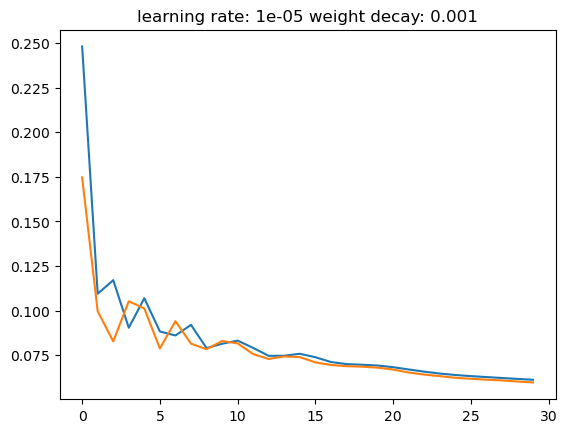

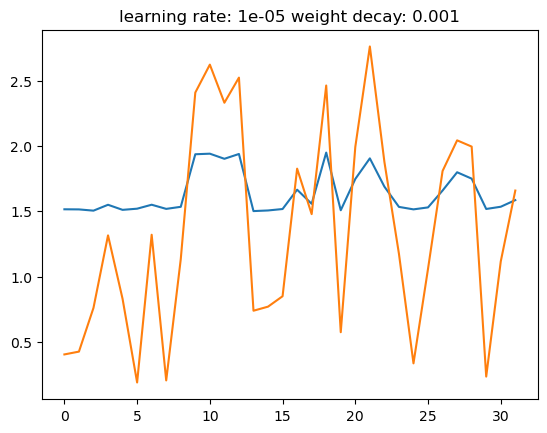

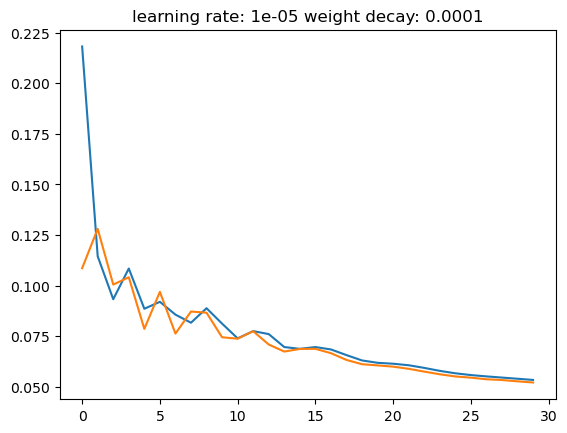

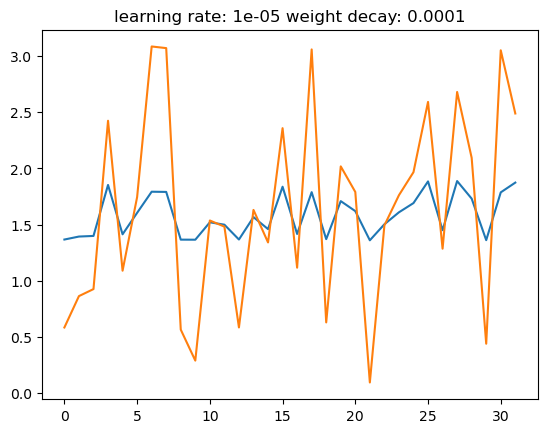

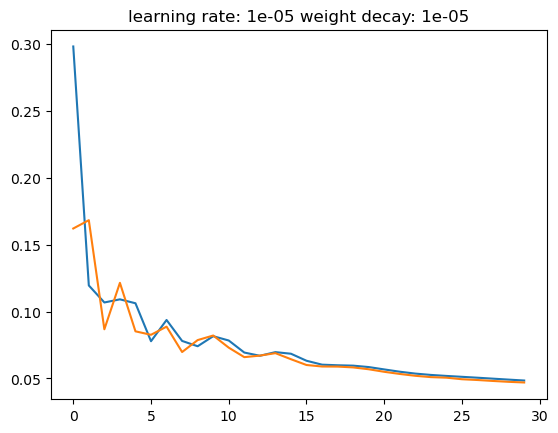

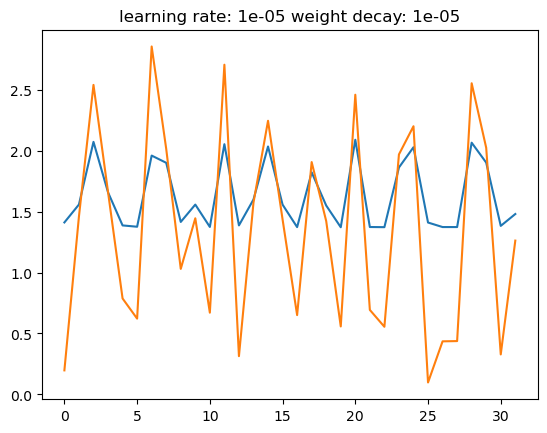

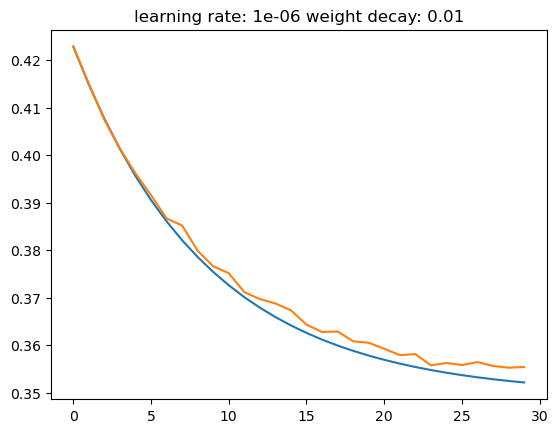

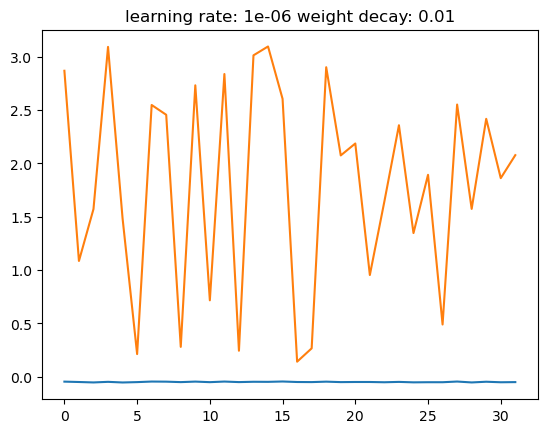

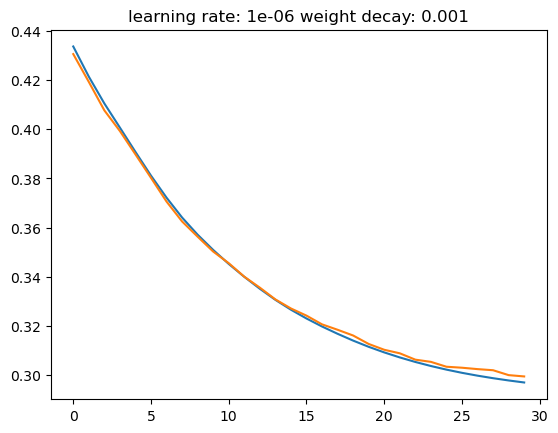

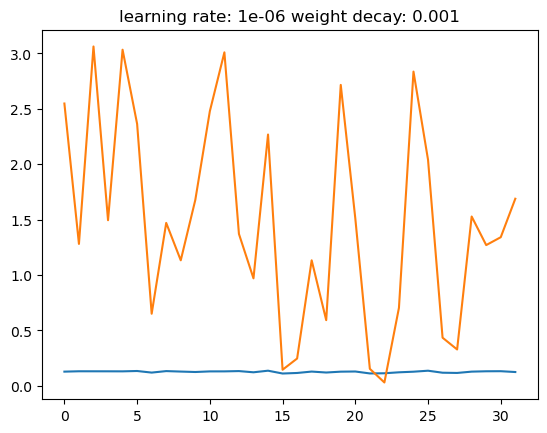

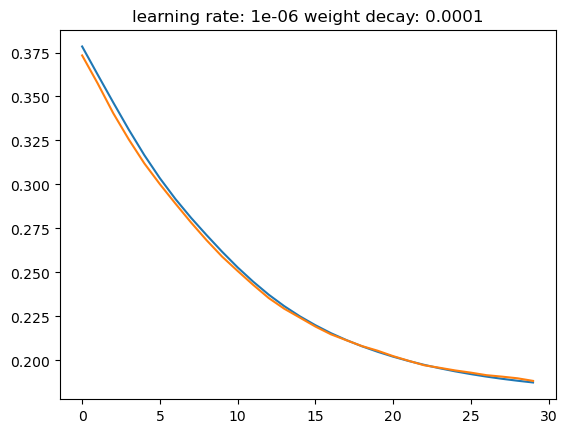

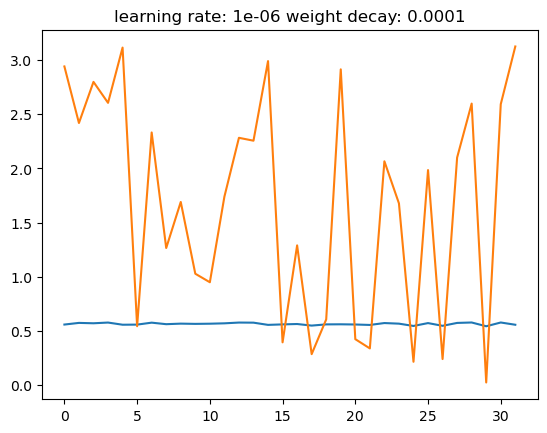

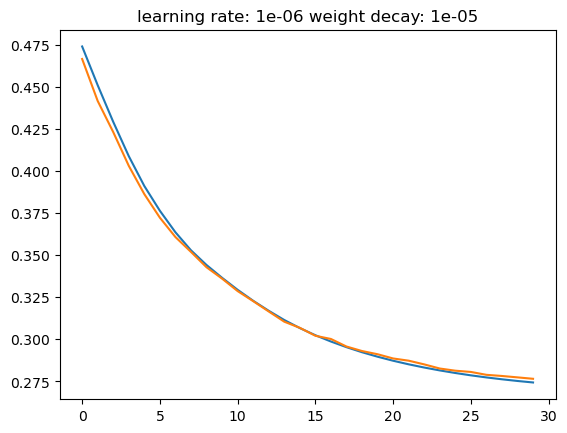

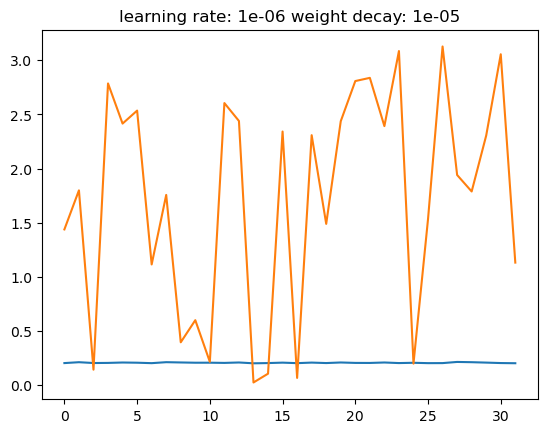

In [11]:
for lr in [1e-3,1e-4,1e-5,1e-6]:
    for wd in [1e-2,1e-3,1e-4,1e-5]:
        #lr = 1e-3
        #wd = 1e-3
        del model
        model = Net()
        
        epochs = 30
        optimizer = torch.optim.Adam(
                model.parameters(),
                lr           = lr,
                weight_decay = wd
            )

        #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

        gamma = 0.9#0.85
        scheduler_step_size = 1
        scheduler = lr_scheduler.StepLR(
            optimizer, 
            step_size = scheduler_step_size, 
            gamma     = gamma)

        # scheduler = lr_scheduler.ExponentialLR(
        #     optimizer, 
        #     #step_size = scheduler_step_size, 
        #     gamma     = gamma)

        train_losses = []
        val_losses   = []
        lrs          = []
        for epoch in range(epochs):
            train_loss = train_one_epoch(model,optimizer)
            val_loss   = validate_one_epoch(model,optimizer)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            lrs.append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step()
            #print("EPOCH: ",epoch + 1, " Train loss: ", round(train_loss,4), " Val loss: ",round(val_loss,4), " LR: ",round(scheduler.optimizer.param_groups[0]['lr'],10))

        txt = "learning rate: " + str(lr) +  " weight decay: " + str(wd)
        plt.title(txt)
        plt.plot(train_losses)
        plt.plot(val_losses)
        plt.show()
        
        for batch in validation_generator:
            break
        output = model(batch[0])
        output
        plt.title(txt)
        plt.plot(output.detach().numpy()*3.1415926)
        plt.plot(batch[1].detach().numpy()*3.1415926)
        plt.show()